In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)
from sklearn.calibration import calibration_curve
from scipy.stats import chi2


In [2]:
file_path = './data/alzheimers_disease_data.csv'
alzheimers_data = pd.read_csv(file_path)

In [3]:
internal_factors_keys = [
    "Age", "Gender", "Ethnicity", "BMI", "FamilyHistoryAlzheimers",
    "CardiovascularDisease", "Diabetes", "Depression", "Hypertension",
    "SystolicBP", "DiastolicBP", "CholesterolTotal", "CholesterolLDL",
    "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment",
    "MemoryComplaints", "BehavioralProblems", "ADL", "Confusion",
    "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks",
    "Forgetfulness", "HeadInjury"
]
external_factors_keys = ["EducationLevel", "Smoking", "AlcoholConsumption",
                         "PhysicalActivity", "DietQuality", "SleepQuality"]

In [4]:
df = alzheimers_data
df.columns = df.columns.str.strip()

### Logistic regression

Using forward modelling selection with the usage of BIC, we tried to find variables to use for the logistic regression model. In the first code box below, we used the five variables that showed a (small) correlation in the visualisations.

In [5]:
# Logistic regression model with ['MemoryComplaints', 'BehavioralProblems',
#                                 'MMSE', 'ADL', 'FunctionalAssessment']

y = alzheimers_data['Diagnosis'].astype(int)
X = alzheimers_data[['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'ADL', 'FunctionalAssessment']]
X_sm = sm.add_constant(X)

model = sm.Logit(y, X_sm).fit()
print(model.summary())

bic_value = model.bic
print(f"BIC value for the given model: {bic_value}")


Optimization terminated successfully.
         Current function value: 0.374126
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2143
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.4241
Time:                        16:30:06   Log-Likelihood:                -804.00
converged:                       True   LL-Null:                       -1396.2
Covariance Type:            nonrobust   LLR p-value:                7.292e-254
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.8610      0.231     16.684      0.000       3.407       4.315

Takes the predictors and calculates which model is the best with the use of BIC. The code below looks at the variables and adds the one with the best (lowest) BIC score. It keeps on doing this until it cannot imnprove the BIC score anymore. Then, it adds the remaining variables so you can see in the graph that the BIC score gets worse the more variables you add from that point on. 

Best combination of predictors: ['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'BehavioralProblems', 'MMSE']
Best BIC: 1654.0285326599942
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2143
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.4241
Time:                        16:30:08   Log-Likelihood:                -804.00
converged:                       True   LL-Null:                       -1396.2
Covariance Type:            nonrobust   LLR p-value:                7.292e-254
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.8610      0.231     

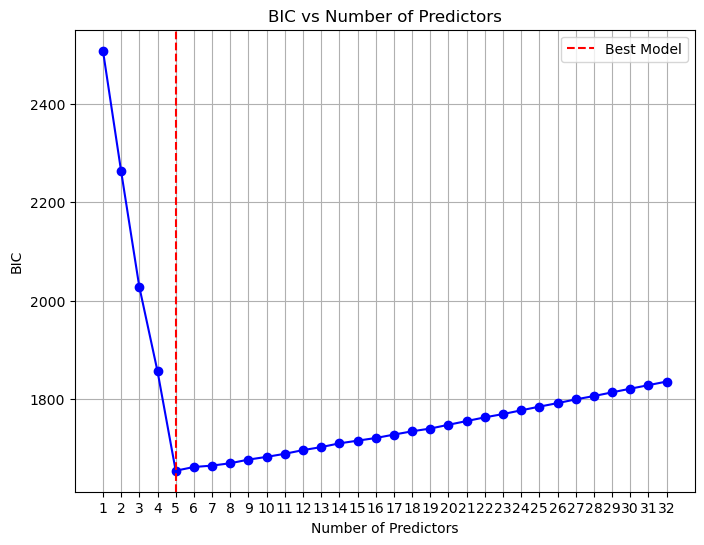

In [6]:
# Here we combine the factors to use all the predictors.
predictors = internal_factors_keys + external_factors_keys


def fit_model(X):
    X_sm = sm.add_constant(X)
    model_sm = sm.Logit(y, X_sm).fit(disp=0)
    return model_sm.bic, model_sm


def print_model_formula(model, predictors):
    coef = model.params
    formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
    for i, predictor in enumerate(predictors):
        formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
    print("Logistic Regression Formula:")
    print(formula)


bic_values = []
best_bic = float('inf')
best_model = None
selected_predictors = []
remaining_predictors = set(predictors)

# Step 1: Find the best initial predictor
best_initial_bic = float('inf')
best_initial_predictor = None

for predictor in remaining_predictors:
    X = alzheimers_data[[predictor]]
    bic, _ = fit_model(X)
    if bic < best_initial_bic:
        best_initial_bic = bic
        best_initial_predictor = predictor

selected_predictors.append(best_initial_predictor)
bic_values.append(best_initial_bic)
best_bic = best_initial_bic
remaining_predictors.remove(best_initial_predictor)

# Step 2: Iteratively add predictors that improve the BIC
while remaining_predictors:
    best_new_bic = float('inf')
    best_new_predictor = None

    for predictor in remaining_predictors:
        X = alzheimers_data[selected_predictors + [predictor]]
        bic, _ = fit_model(X)
        if bic < best_new_bic:
            best_new_bic = bic
            best_new_predictor = predictor

    # Check if adding the new predictor improves the BIC
    if best_new_bic < best_bic:
        best_bic = best_new_bic
        selected_predictors.append(best_new_predictor)
        bic_values.append(best_bic)
        remaining_predictors.remove(best_new_predictor)

        # Save the current best model
        X_best = alzheimers_data[selected_predictors]
        X_best_sm = sm.add_constant(X_best)
        _, best_model = fit_model(X_best)
    else:
        break

# Step 3: Add remaining predictors to complete the graph
for predictor in remaining_predictors:
    selected_predictors.append(predictor)
    X = alzheimers_data[selected_predictors]
    bic, _ = fit_model(X)
    bic_values.append(bic)

print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
print(f"Best BIC: {best_bic}")
print(best_model.summary())
print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
plt.title('BIC vs Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')
plt.xticks(range(1, len(bic_values) + 1))
plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
plt.legend()
plt.grid(True)
plt.show()


From here on, the same is done but the columns are seperated based on the ethnicity. So per column, 4 new columns are added (for ethnicity 0-3)

In [7]:
df_2 = alzheimers_data

In [8]:
#combine all predictors
all_predictors = internal_factors_keys + external_factors_keys

In [9]:
predictors_on_ethnicity = []

# Create subset columns and add their names to the list
for predictor in all_predictors:
    for ethnicity in df_2['Ethnicity'].unique():
        col_name = f'{predictor}_{ethnicity}'
        df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
        predictors_on_ethnicity.append(col_name)



/tmp/ipykernel_5110/4151971580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
/tmp/ipykernel_5110/4151971580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_2[col_name] = df_2.loc[df_2['Ethnicity'] == ethnicity, predictor].fillna(0)
/tmp/ipykernel_5110/4151971580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

In [10]:
def write_df_to_csv(df, file_name):
    """
    Writes the provided DataFrame to a CSV file.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to write.
    file_name (str): The name of the CSV file to save the DataFrame.
    """
    df.to_csv(file_name, index=False)  # index=False prevents writing row indices
    print(f"DataFrame successfully written to {file_name}")

In [11]:
write_df_to_csv(df_2, 'analysis.csv')

DataFrame successfully written to analysis.csv


The code below fills in all the Nan in the dataframe. It does this by firstly iterating over all columns. In the column, it checks if there are any Nan. If it finds a Nan, it looks at the diagnosis of the row. Then, it takes a random value out of that column with the same diagnosis score and fills it in. 

In [12]:
# Fill in the Nan by randomly replacing it by another value of that column,
# but checking if the 'diagnosis' value is the same of the one that it replaces
# it with.


def random_impute_by_diagnosis(df, column, diagnosis_column='Diagnosis'):
    for idx, row in df.iterrows():
        if pd.isna(row[column]):
            diagnosis_value = row[diagnosis_column]
            subset = df[df[diagnosis_column] == diagnosis_value]

            # Get the non-NaN values of the current column from the subset
            non_missing_values = subset[column].dropna().values

            if len(non_missing_values) > 0:
                # Randomly select a value from the non-missing values
                random_value = np.random.choice(non_missing_values)

                # Replace the NaN with the randomly selected value
                df.at[idx, column] = random_value

    print(f"Imputation for column '{column}' completed successfully.")
    return df


In [13]:
columns = df_2.columns
for column in columns:
    df_2 = random_impute_by_diagnosis(df_2, column)

# This can take a while

Imputation for column 'PatientID' completed successfully.
Imputation for column 'Age' completed successfully.
Imputation for column 'Gender' completed successfully.
Imputation for column 'Ethnicity' completed successfully.
Imputation for column 'EducationLevel' completed successfully.
Imputation for column 'BMI' completed successfully.
Imputation for column 'Smoking' completed successfully.
Imputation for column 'AlcoholConsumption' completed successfully.
Imputation for column 'PhysicalActivity' completed successfully.
Imputation for column 'DietQuality' completed successfully.
Imputation for column 'SleepQuality' completed successfully.
Imputation for column 'FamilyHistoryAlzheimers' completed successfully.
Imputation for column 'CardiovascularDisease' completed successfully.
Imputation for column 'Diabetes' completed successfully.
Imputation for column 'Depression' completed successfully.
Imputation for column 'HeadInjury' completed successfully.
Imputation for column 'Hypertension'

In [14]:
df_3 = df_2

In [15]:
# Because it took 30 minutes to make this df, it is saved to a csv file so it
# can easily be read again when opening up ipynb again instead of having to do
# this all over again.
write_df_to_csv(df_3, 'analysis_2.csv')

DataFrame successfully written to analysis_2.csv


In [16]:
# Drop these ethnicity columns since we are already looking at them per variable
df_3.drop(columns=['Ethnicity_0'], inplace=True)
df_3.drop(columns=['Ethnicity_1'], inplace=True)
df_3.drop(columns=['Ethnicity_2'], inplace=True)
df_3.drop(columns=['Ethnicity_3'], inplace=True)


In [17]:
# Drop the ethnicity column names in the list with column names
predictors_2 = predictors_on_ethnicity
predictors_2.remove("Ethnicity_0")
predictors_2.remove("Ethnicity_1")
predictors_2.remove("Ethnicity_2")
predictors_2.remove("Ethnicity_3")

Down here is the logistic regression fit again and the BIC used to determine the best model

Best combination of predictors: ['FunctionalAssessment_2', 'ADL_1', 'MemoryComplaints_1', 'FunctionalAssessment_3', 'FunctionalAssessment_1', 'MemoryComplaints_3', 'MemoryComplaints_2', 'FunctionalAssessment_0', 'MMSE_3', 'MemoryComplaints_0', 'MMSE_0', 'ADL_0', 'BehavioralProblems_0', 'ADL_3', 'BehavioralProblems_1', 'CholesterolTriglycerides_2', 'ADL_2', 'SystolicBP_1', 'MMSE_1', 'MMSE_2', 'Depression_2', 'Disorientation_2', 'Disorientation_1', 'AlcoholConsumption_3', 'Confusion_3', 'Depression_0', 'Gender_2', 'Disorientation_3', 'BehavioralProblems_2']
Best BIC: 621.2916366187321
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2119
Method:                           MLE   Df Model:                           29
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.8599
Time:          

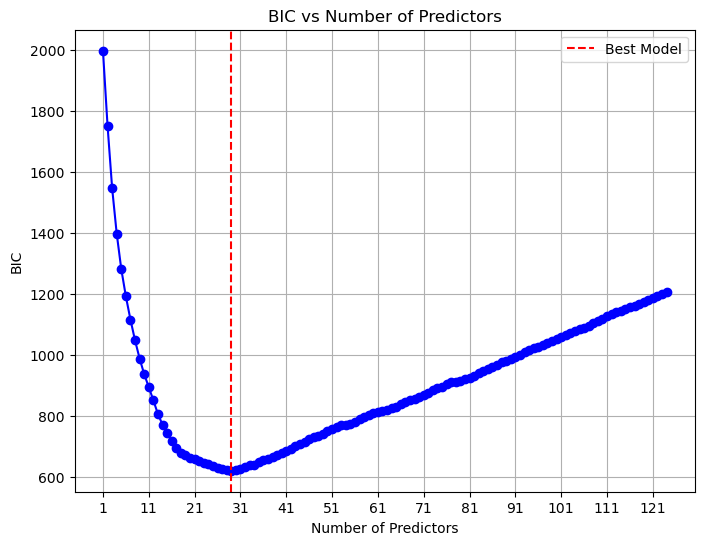

In [18]:

# Define the target variable (Diagnosis) and predictor variables 
y = df_3['Diagnosis'].astype(int)

# Create a list of all potential predictor variables
predictors = predictors_2


def fit_model(X):
    """
    # Function to fit logistic regression and calculate BIC
    def fit_model(X):
        X_sm = sm.add_constant(X)  # Add a constant for the intercept term
        model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
        return model_sm.bic, model_sm  # Return the BIC value and model
    """
    X_sm = sm.add_constant(X)  # Add a constant for the intercept term
    try:
        model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
        return model_sm.bic, model_sm  # Return the BIC value and model
    except np.linalg.LinAlgError:  # Catch singular matrix error
        print("Singular matrix error with predictors:", X.columns)
        return np.inf, None  # Return an infinite BIC value to discard this model


def print_model_formula(model, predictors):
    coef = model.params
    formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
    for i, predictor in enumerate(predictors):
        formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
    print("Logistic Regression Formula:")
    print(formula)


bic_values = []
best_bic = float('inf')
best_model = None
selected_predictors = []
remaining_predictors = set(predictors)

# Step 1: Find the best initial predictor
best_initial_bic = float('inf')
best_initial_predictor = None

for predictor in remaining_predictors:
    X = df_3[[predictor]]
    bic, _ = fit_model(X)
    if bic < best_initial_bic:
        best_initial_bic = bic
        best_initial_predictor = predictor

selected_predictors.append(best_initial_predictor)
bic_values.append(best_initial_bic)
best_bic = best_initial_bic
remaining_predictors.remove(best_initial_predictor)

# Step 2: Iteratively add predictors that improve the BIC
while remaining_predictors:
    best_new_bic = float('inf')
    best_new_predictor = None

    for predictor in remaining_predictors:
        X = df_3[selected_predictors + [predictor]]
        bic, _ = fit_model(X)
        if bic < best_new_bic:
            best_new_bic = bic
            best_new_predictor = predictor

    if best_new_bic < best_bic:
        best_bic = best_new_bic
        selected_predictors.append(best_new_predictor)
        bic_values.append(best_bic)
        remaining_predictors.remove(best_new_predictor)

        X_best = df_3[selected_predictors]
        X_best_sm = sm.add_constant(X_best)
        _, best_model = fit_model(X_best)
    else:
        break

# Step 3: Add remaining predictors to complete the graph
for predictor in remaining_predictors:
    selected_predictors.append(predictor)
    X = df_3[selected_predictors]
    bic, _ = fit_model(X)
    bic_values.append(bic)

print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
print(f"Best BIC: {best_bic}")
print(best_model.summary())
print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
plt.title('BIC vs Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')
plt.xticks(range(1, len(bic_values) + 1, 10))
plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
plt.legend()
plt.grid(True)
plt.show()


From here on, the same is done as above. So the logistic regression is fit with the help of BIC. However, since making the dataframe with the columns seperated on ethnicity took very long, if the outputs are somehow deleted, down here is a quicker version that reads the already edited csv file in a dataframe. As you can see all the way at the bottom, the results are the same. 

In [19]:
file_path = 'analysis_2.csv'
alzheimers_data_new_columns = pd.read_csv(file_path)

In [20]:
def log_regression_bic(df, predictors):
    y = df['Diagnosis'].astype(int)

    # Create a list of all potential predictor variables
    predictors = predictors

    def fit_model(X):
        """
        # Function to fit logistic regression and calculate BIC
        def fit_model(X):
            X_sm = sm.add_constant(X)  # Add a constant for the intercept term
            model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
            return model_sm.bic, model_sm  # Return the BIC value and model
        """
        X_sm = sm.add_constant(X)  # Add a constant for the intercept term
        try:
            model_sm = sm.Logit(y, X_sm).fit(disp=0)  # Fit the logistic regression model
            return model_sm.bic, model_sm  # Return the BIC value and model
        except np.linalg.LinAlgError:  # Catch singular matrix error
            print("Singular matrix error with predictors:", X.columns)
            return np.inf, None  # Return an infinite BIC value to discard this model

    def print_model_formula(model, predictors):
        coef = model.params
        formula = f"y = {coef.iloc[0]:.4f}"  # Intercept
        for i, predictor in enumerate(predictors):
            formula += f" + ({coef.iloc[i + 1]:.4f} * {predictor})"
        print("Logistic Regression Formula:")
        print(formula)

    bic_values = []
    best_bic = float('inf')
    best_model = None
    selected_predictors = []
    remaining_predictors = set(predictors)

    # Step 1: Find the best initial predictor
    best_initial_bic = float('inf')
    best_initial_predictor = None

    for predictor in remaining_predictors:
        X = df[[predictor]]
        bic, _ = fit_model(X)
        if bic < best_initial_bic:
            best_initial_bic = bic
            best_initial_predictor = predictor

    # Update lists and variables after selecting the first predictor
    selected_predictors.append(best_initial_predictor)
    bic_values.append(best_initial_bic)
    best_bic = best_initial_bic
    remaining_predictors.remove(best_initial_predictor)

    # Step 2: Iteratively add predictors that improve the BIC
    while remaining_predictors:
        best_new_bic = float('inf')
        best_new_predictor = None

        for predictor in remaining_predictors:
            X = df[selected_predictors + [predictor]]
            bic, _ = fit_model(X)
            if bic < best_new_bic:
                best_new_bic = bic
                best_new_predictor = predictor

        if best_new_bic < best_bic:
            best_bic = best_new_bic
            selected_predictors.append(best_new_predictor)
            bic_values.append(best_bic)
            remaining_predictors.remove(best_new_predictor)

            X_best = df[selected_predictors]
            X_best_sm = sm.add_constant(X_best)
            _, best_model = fit_model(X_best)
        else:
            break

    # Step 3: Add remaining predictors to complete the graph
    for predictor in remaining_predictors:
        selected_predictors.append(predictor)
        X = df[selected_predictors]
        bic, _ = fit_model(X)
        bic_values.append(bic)

    print(f"Best combination of predictors: {selected_predictors[:bic_values.index(best_bic) + 1]}")
    print(f"Best BIC: {best_bic}")
    print(best_model.summary())
    print_model_formula(best_model, selected_predictors[:bic_values.index(best_bic) + 1])

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='b')
    plt.title('BIC vs Number of Predictors')
    plt.xlabel('Number of Predictors')
    plt.ylabel('BIC')
    plt.xticks(range(1, len(bic_values) + 1, 10))
    plt.axvline(x=bic_values.index(best_bic) + 1, color='r', linestyle='--', label='Best Model')
    plt.legend()
    plt.grid(True)
    plt.show()


In [21]:
alzheimers_data_new_columns.columns = alzheimers_data_new_columns.columns.str.strip()
alzheimers_data_new_columns.drop(columns=['Ethnicity_0'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_1'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_2'], inplace=True)
alzheimers_data_new_columns.drop(columns=['Ethnicity_3'], inplace=True)


Best combination of predictors: ['FunctionalAssessment_2', 'ADL_1', 'MemoryComplaints_1', 'FunctionalAssessment_3', 'FunctionalAssessment_1', 'MemoryComplaints_3', 'MemoryComplaints_2', 'FunctionalAssessment_0', 'MMSE_3', 'MemoryComplaints_0', 'MMSE_0', 'ADL_0', 'BehavioralProblems_0', 'ADL_3', 'BehavioralProblems_1', 'CholesterolTriglycerides_2', 'ADL_2', 'SystolicBP_1', 'MMSE_1', 'MMSE_2', 'Depression_2', 'Disorientation_2', 'Disorientation_1', 'AlcoholConsumption_3', 'Confusion_3', 'Depression_0', 'Gender_2', 'Disorientation_3', 'BehavioralProblems_2']
Best BIC: 621.2916366187322
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2119
Method:                           MLE   Df Model:                           29
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.8599
Time:          

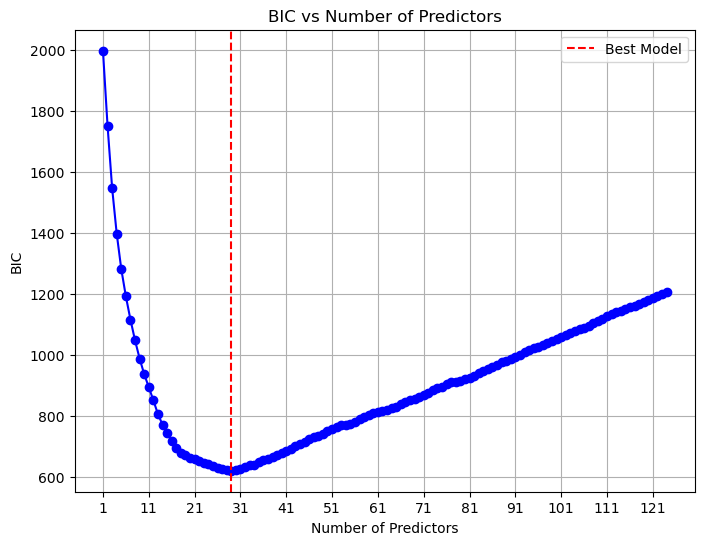

In [22]:
log_regression_bic(df=alzheimers_data_new_columns, predictors=predictors_2)

To test the network, we used 80% of the data to train it and 20% to test it (cross-validation).

In [23]:
y = alzheimers_data['Diagnosis'].astype(int)
X = alzheimers_data[['MemoryComplaints', 'BehavioralProblems', 'MMSE', 'ADL', 'FunctionalAssessment']]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)

model = sm.Logit(y_train, X_train_sm).fit()

print(model.summary())

X_test_sm = sm.add_constant(X_test)
y_pred = model.predict(X_test_sm)

Optimization terminated successfully.
         Current function value: 0.372994
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 1719
Model:                          Logit   Df Residuals:                     1713
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.4256
Time:                        16:35:32   Log-Likelihood:                -641.18
converged:                       True   LL-Null:                       -1116.2
Covariance Type:            nonrobust   LLR p-value:                3.776e-203
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.9072      0.260     15.016      0.000       3.397       4.417

To evaluate the model:

The Hosmer-Lemeshow test is a statistical test used to assess how well a logistic regression model fits the observed data. It is commonly used to check if the predicted probabilities from the model match the actual outcomes. It tests whether the observed event rates match the expected event rates in subgroups of the data.

The test works by grouping predicted probabilities into intervals (deciles), calculating the observed and expected number of events (e.g., binary outcomes like success/failure), and comparing them. A significant p-value (typically < 0.05) suggests that the model does not fit the data well, while a non-significant p-value suggests that the model fits the data adequately.

In [24]:
# Hosmer-Lemeshow Goodness-of-Fit Test
data = X_test.copy()
data['predicted'] = y_pred
data['actual'] = y_test

# Group predictions into deciles
data['decile'] = pd.qcut(data['predicted'], 10, labels=False)

# Calculate observed and expected counts
observed = data.groupby('decile')['actual'].sum()
expected = data.groupby('decile')['predicted'].sum()

# Compute HL test statistic
hl_stat = ((observed - expected) ** 2 / expected).sum()
p_value = chi2.sf(hl_stat, df=8)  # Degrees of freedom = number of deciles - 2

print(f"Hosmer-Lemeshow Test Statistic: {hl_stat:.2f}, p-value: {p_value:.4f}")

Hosmer-Lemeshow Test Statistic: 11.37, p-value: 0.1817


In [25]:
# Calculate the observed and expected counts (this part remains the same from before)
observed = data.groupby('decile')['actual'].sum()
expected = data.groupby('decile')['predicted'].sum()

# Compute the Pearson chi-squared test statistic
chi_squared_stat = ((observed - expected) ** 2 / expected).sum()

# Degrees of freedom = number of deciles - 1
# Since there are 10 deciles, the degrees of freedom will be 10 - 1 = 9
df = len(observed) - 1

# Compute the p-value
p_value = chi2.sf(chi_squared_stat, df)

# Output the result
print(f"Pearson Chi-Squared Test Statistic: {chi_squared_stat:.2f}, p-value: {p_value:.4f}")


Pearson Chi-Squared Test Statistic: 11.37, p-value: 0.2513


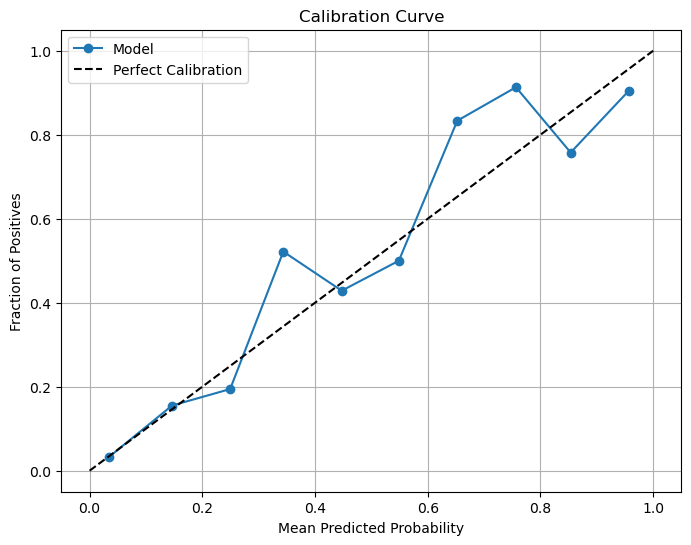

In [26]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()

### ROC curve

ROC AUC: 0.9015
Precision: 0.7929
Recall: 0.7255
F1-Score: 0.7577


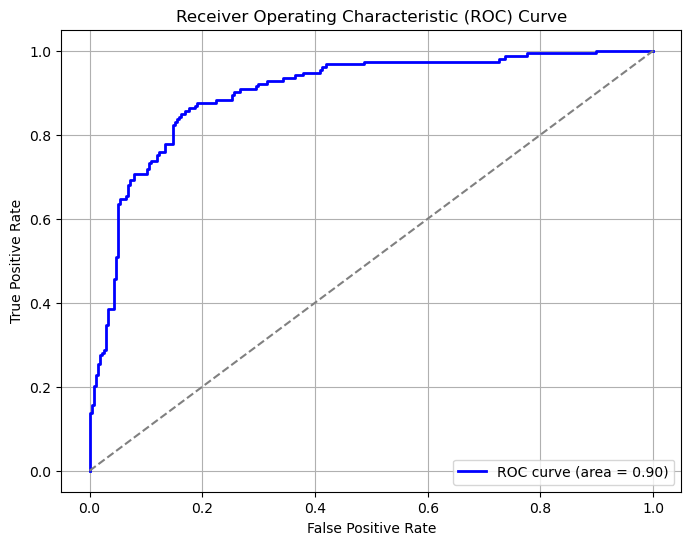

In [27]:
# Additional Metrics Evaluation
# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.4f}")

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()